In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

from cartesian_explorer import Explorer
import cartesian_explorer as caex

import qtensor
import pickle
import miplog_helper

2021-11-11 02:05:27,450- WARNING•	QuickBB solver is unavailable


twl /home/dlykov/anl/Qensor/qtree/thirdparty/tamaki_treewidth/tw-exact


In [2]:
from datetime import datetime, timedelta
from functools import wraps

class throttle():
    """ Decorator class that limits number of calls for function"""
    def __init__(self, per_sec=20):
        self.period = timedelta(microseconds=1000000/per_sec)
        self.t0 = datetime.min

    def __call__(self, fn):
        @wraps(fn)
        def wrapper(*args, **kwargs):
            t1 = datetime.now()
            dt = t1 - self.t0
            secs2wait = (self.period - dt).total_seconds()
            if secs2wait > 0:
                return 

            self.t0 = datetime.now()
            return fn(*args, **kwargs)

        return wrapper

In [3]:
import networkx as nx
from typing import Tuple
import gurobipy as gb
import time

def maxcut_bounds_history(G: nx.Graph,
                          max_time=10*60,
                          max_cost=None,
                          threads=None,
                          timedelta=3,
                          max_ar=1.0,
                          verbose=True,
                          callback=None,
                          gurobi_options={}
                         ) -> Tuple[list, list]:
    p = gb.Model()
    p.setParam('TimeLimit', max_time)
    if max_cost is not None:
        p.setParam('BestObjStop', max_cost)
    if threads is not None:
        p.setParam('Threads', threads)
    if verbose is False:
        p.setParam('OutputFlag', 0)
    for key in gurobi_options:
        p.setParam(key, gurobi_options[key])
        
    vdict = {}
    for n in G.nodes:
        vdict[n] = p.addVar(name='v_'+str(n), vtype=gb.GRB.BINARY)
    scaled_v = {v:(2*x - 1) for v, x in vdict.items()}
    C_i = [vdict[i] + vdict[j] - 2*vdict[i]*vdict[j] for i, j in G.edges]
    
    p.setObjective(sum(C_i), gb.GRB.MAXIMIZE)
    
    startop = time.time()
    upper = []
    lower = []
    def clb(model, where):
        # See here https://www.gurobi.com/documentation/9.1/refman/cb_codes.html
        return None
        
    miplog = []
    start = time.time()

    @throttle(per_sec=1)
    def on_update(model, where, cost, bound):
        nonlocal start
        if start == 0:
            start = time.time()
        dt = time.time()-start
        miplog.append([dt, bound, cost])
        print(f'[{dt}]', 'MIP', 'cost=', cost, 'bound=', bound)

    def clb(model, where):
        # See here https://www.gurobi.com/documentation/9.1/refman/cb_codes.html
        if where == gb.CallbackClass.MIP:
            cst = model.cbGet(gb.CallbackClass.MIP_OBJBST)
            bnd = model.cbGet(gb.CallbackClass.MIP_OBJBND)
            on_update(model, where, cst, bnd)
        if where == gb.CallbackClass.MIPSOL:
            cst = model.cbGet(gb.CallbackClass.MIPSOL_OBJBST)
            bnd = model.cbGet(gb.CallbackClass.MIPSOL_OBJBND)
            on_update(model, where, cst, bnd)
        
    if callback is None:
        callback = clb
        
    p.optimize(callback=callback)
    miplog.append(
        [time.time()-startop, p.ObjBound, p.ObjVal]
    )
        
    return miplog


In [4]:
GUROBI_THREADS = 1 #set to 0 to use all available

In [8]:
N = 256
seed = 32
degree = 3
graph = qtensor.toolbox.random_graph(nodes=N, seed=seed, degree=degree)

In [9]:
max_time = 600
gurobi_options = {'Symmetry': 0, 'PreQLinearize': 2}
    
miplog = maxcut_bounds_history(
    graph, max_time=max_time, threads=GUROBI_THREADS,
    gurobi_options=gurobi_options
)


Academic license - for non-commercial use only - expires 2022-01-09
Using license file /home/dlykov/git-build/gurobi/gurobi.lic
Changed value of parameter TimeLimit to 600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter Threads to 1
   Prev: 0  Min: 0  Max: 1024  Default: 0
Changed value of parameter Symmetry to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter PreQLinearize to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 56 physical cores, 112 logical processors, using up to 1 threads
Optimize a model with 0 rows, 256 columns and 0 nonzeros
Model fingerprint: 0x15885010
Model has 384 quadratic objective terms
Variable types: 0 continuous, 256 integer (256 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
[0.02357912063

[79.54444575309753] MIP cost= 351.0 bound= 359.0
  9969  3593  352.79827   29  256  351.00000  359.40312  2.39%   153   80s
[80.55140709877014] MIP cost= 351.0 bound= 359.0
[81.5578293800354] MIP cost= 351.0 bound= 359.0
[88.48605370521545] MIP cost= 351.0 bound= 359.0
 10203  3664  354.37100   25  103  351.00000  359.35237  2.38%   154   88s
[89.50880074501038] MIP cost= 351.0 bound= 359.0
 10247  3695  359.35237   23  321  351.00000  359.35237  2.38%   154   90s
[90.6088879108429] MIP cost= 351.0 bound= 359.0
[91.61312246322632] MIP cost= 351.0 bound= 359.0
[92.61552143096924] MIP cost= 351.0 bound= 359.0
[93.61590957641602] MIP cost= 351.0 bound= 359.0
[94.62393116950989] MIP cost= 351.0 bound= 359.0
 10687  3850  358.83891   25  325  351.00000  359.35237  2.38%   155   95s
[95.62675285339355] MIP cost= 351.0 bound= 359.0
[96.64089035987854] MIP cost= 351.0 bound= 359.0
[97.64493131637573] MIP cost= 351.0 bound= 359.0
[98.65545272827148] MIP cost= 351.0 bound= 358.0
[99.662207841873

In [10]:
dh = miplog_helper.MiplogData(miplog)
diffs = dh.get_diff_data()
start = dh.get_starting_point()
gurobi_hist =  [start] + diffs

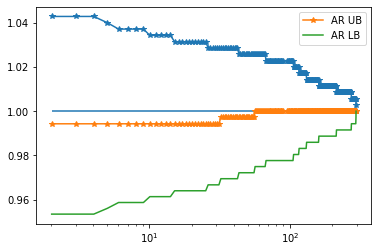

In [11]:
dh.plot()

In [12]:
pickle.dump(gurobi_hist, open(f'../gurobi_single_N{N}_s{seed}.pkl', 'wb+'))

## Multiple seeds

In [15]:
from cartesian_explorer import parallels

In [16]:
par = parallels.Ray(processes=56)

In [17]:
def unit(seed):
    N = 256
    degree = 3
    graph = qtensor.toolbox.random_graph(nodes=N, seed=seed, degree=degree)
    max_time = 60
    gurobi_options = {'Symmetry': 0, 'PreQLinearize': 2}

    miplog = maxcut_bounds_history(
        graph, max_time=max_time, threads=GUROBI_THREADS,
        gurobi_options=gurobi_options
    )
    return miplog

In [25]:
%%time
seeds = range(5)
result =  par.map(unit, seeds)

CPU times: user 742 ms, sys: 67.4 ms, total: 809 ms
Wall time: 1min


In [20]:
pickle.dump(gurobi_hist, open(f'../gurobi_single_N{N}_seeds{len(seeds)}.pkl', 'wb+'))

ValueError: different number of dimensions on data and dims: 3 vs 1

Activate Gurobi

In [7]:
import socket
if socket.gethostname().startswith('skylake'):
    gurobi_lic = '/home/dlykov/git-build/gurobi/'
    print('getting license')
    grbkey = '1ce6bb18-4294-11ec-b3f6-0242ac120003'
    # (over)write key to gurobi_lic directory and don't ask questions
    !grbgetkey -q --path $gurobi_lic $grbkey

getting license
info  : grbgetkey version 9.1.2, build v9.1.2rc0
info  : Contacting Gurobi license server...
info  : License file for license ID 724584 was successfully retrieved
info  : License expires at the end of the day on 2022-01-09
info  : Saving license file...
info  : License 724584 written to file /home/dlykov/git-build/gurobi/gurobi.lic


---